In [125]:
import matplotlib.pyplot as plt
import sys; sys.path.append("..")
import torch
from model import Dataset, ELM2D

In [126]:
d = next(iter(Dataset("ks2d_short.npy")))

extent = 2
step = 4
hidden = 400 
model = ELM2D((extent,extent),(step,step),hidden)

N0, N1 = d.shape[1:]
maxval, minval = d.max(), d.min()
normalize = lambda x: (x-minval)/(maxval-minval)
denormalize = lambda x: x*(maxval-minval)+minval
D = [normalize(d)]

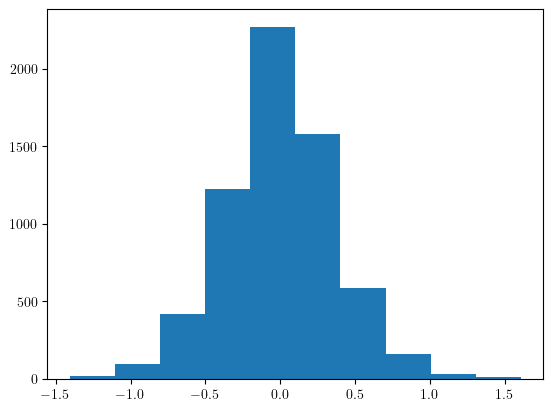

In [127]:
model.train(D, stopping_threshold=1e-4, noise=0)
plt.hist(model.lout.weight.data.flatten())
plt.show()

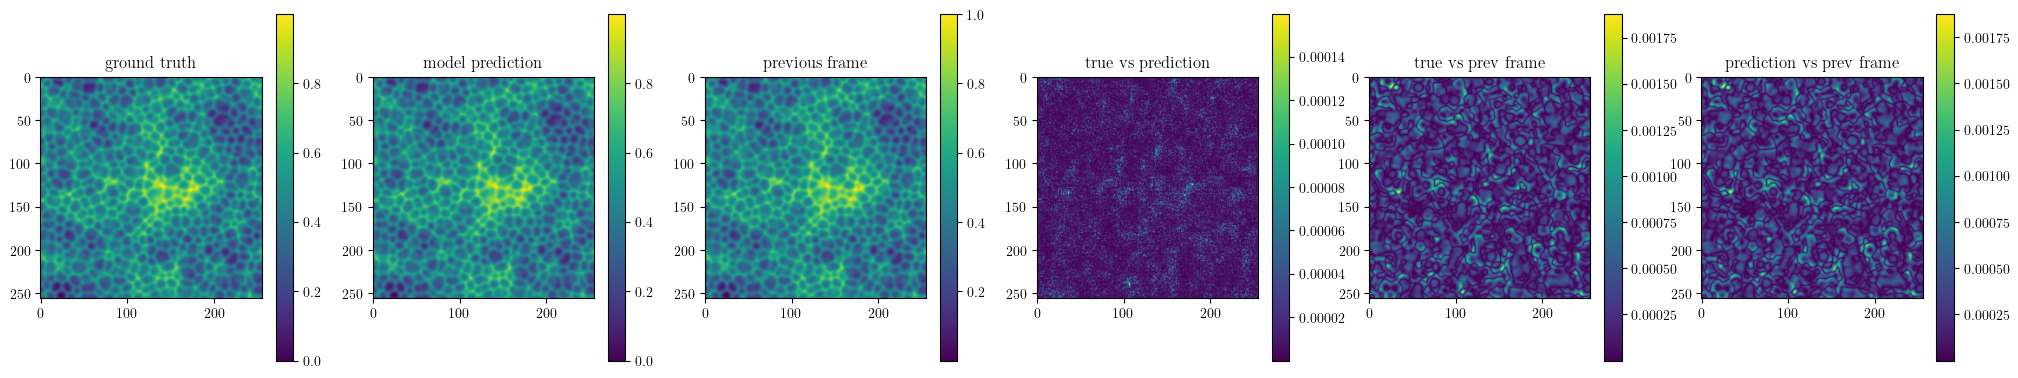

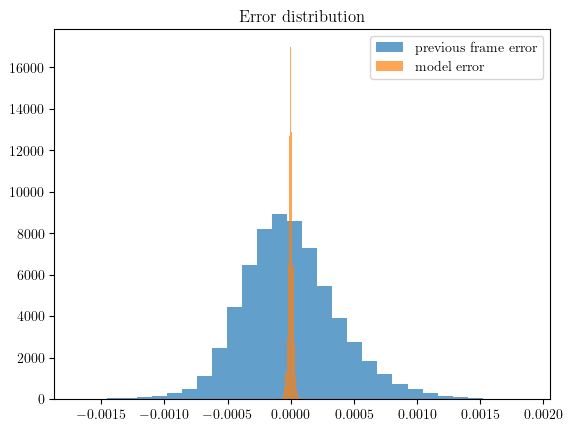

In [128]:
X_test = normalize(d[-2,...])
Y_test = normalize(d[-1,...])
Y_pred =  model(X_test.unsqueeze(0)).detach().squeeze(0)

fig, ax = plt.subplots(1,6,figsize=(25,15))
plt.colorbar(ax[0].imshow(Y_test),shrink=0.3)
ax[0].set_title("ground truth")
plt.colorbar(ax[1].imshow(Y_pred),shrink=0.3)
ax[1].set_title("model prediction")
plt.colorbar(ax[2].imshow(X_test),shrink=0.3)
ax[2].set_title("previous frame")

model_error = Y_pred - Y_test
plt.colorbar(ax[3].imshow(model_error.abs()),shrink=0.3)
ax[3].set_title("true vs prediction")
prev_error = X_test - Y_test
plt.colorbar(ax[4].imshow(prev_error.abs()),shrink=0.3)
ax[4].set_title("true vs prev frame")

model_error_prev = Y_pred - X_test
plt.colorbar(ax[5].imshow(model_error_prev.abs()),shrink=0.3)
ax[5].set_title("prediction vs prev frame")
plt.show()

plt.hist(prev_error.flatten(), bins=30, label="previous frame error", alpha=0.7)
plt.hist(model_error.flatten(), bins=30, label="model error", alpha=0.7)
plt.title("Error distribution")
plt.legend()
plt.show()

In [129]:
from tqdm.notebook import tqdm

d = next(iter(Dataset("ks2d_long.npy")))
d_pred = torch.empty(*d.shape)
T = normalize(d[0,...])
for j in tqdm(range(d.shape[0])):
    d_pred[j,...] = T
    for _ in range(50): # 0.5s
        T = model(T[None,...]).detach().view(*T.shape)

  0%|          | 0/60 [00:00<?, ?it/s]

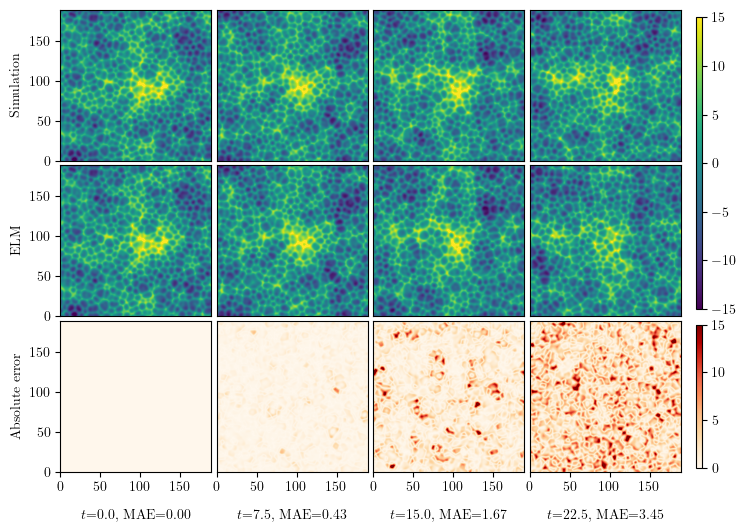

In [130]:
plt_step = 15
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
})

fig, ax = plt.subplots(3, d.shape[0] // plt_step, 
                       figsize=(10,6), gridspec_kw={"wspace":-.1,"hspace":.03})
ext = [0,60*torch.pi,0,60*torch.pi]
for i in range(d.shape[0] // plt_step):
    im1 = ax[0][i].imshow(d[i*plt_step,...].numpy(),vmax=15,vmin=-15,extent=ext)
    im2 = ax[1][i].imshow(denormalize(d_pred[i*plt_step,...]).numpy(),vmax=15,vmin=-15,extent=ext)
    ae =(denormalize(d_pred[i*plt_step,...])-d[i*plt_step,...]).abs()
    im3 = ax[2][i].imshow(ae.numpy(),cmap="OrRd",vmax=15,vmin=0,extent=ext)
    if i > 0:
        ax[0][i].set_yticks([])
        ax[1][i].set_yticks([])
        ax[2][i].set_yticks([])
    if i ==0:
        ax[0][i].yaxis.set_major_locator(plt.MultipleLocator(50))
        ax[1][i].yaxis.set_major_locator(plt.MultipleLocator(50))
        ax[2][i].yaxis.set_major_locator(plt.MultipleLocator(50))
    ax[0][i].set_xticks([])
    ax[1][i].set_xticks([])
    ax[2][i].xaxis.set_major_locator(plt.MultipleLocator(50))

    t = 0.5 * i * plt_step
    mae = ae.mean()
    ax[2][i].text(30*torch.pi,-55,f"$t{{=}}{t:.1f}$, MAE${{=}}{mae:.2f}$",rotation="horizontal",horizontalalignment="center", verticalalignment="center")

ax[0][0].text(-55,30*torch.pi,"Simulation",rotation="vertical",horizontalalignment="center", verticalalignment="center")
ax[1][0].text(-55,30*torch.pi,"ELM",rotation="vertical",horizontalalignment="center", verticalalignment="center")
ax[2][0].text(-55,30*torch.pi,"Absolute error",rotation="vertical",horizontalalignment="center", verticalalignment="center")

plt.colorbar(im1, ax=[ax[i][j] for i in range(2) for j in range(d.shape[0] // plt_step)], shrink=0.95, pad=0.02, aspect=46)
plt.colorbar(im3, ax=[ax[2][j] for j in range(d.shape[0] // plt_step)], shrink=0.95, pad=0.02, aspect=23)

plt.savefig("plots/ks2d.pdf", format="pdf", bbox_inches="tight")
plt.show()